# U-Net: Training Image Segmentation Models in Tensorflow

Copyright 2016 The BigDL Authors.

SparkXshards in Orca allows users to process large-scale dataset using existing Python codes in a distributed and data-parallel fashion, as shown below. This notebook is an example of training U-Net, an image segmentation model in tensforflow on Orca Estimtor and SparkXShard of images. 

It is adapted from [Image segmentation with a U-Net-like architecture](https://keras.io/examples/vision/oxford_pets_image_segmentation/) on [Oxford Pets dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/). 

In [ ]:
# import necessary libraries
from bigdl.orca.data.shard import SparkXShards
import bigdl.orca.data
from bigdl.orca import init_orca_context, stop_orca_context
from bigdl.orca.learn.tf2.estimator import Estimator
import cv2
from tensorflow import keras
import numpy as np
from tensorflow.keras import layers
from IPython.display import display

Start an OrcaContext and give a bit more memory.

In [ ]:
sc = init_orca_context(cluster_mode="local", cores=4, memory="8g")

##  Load images into SparkXShards in parallel

Load data into data_shards, it is a SparkXshards that can be operated on in parallel. Here each record is a tuple of (image: PIL.Image.Image and mask: PIL.Image.Image), and could be operated as usual.

In [3]:
input_dir = "../petsdata/images/"
target_dir = "../petsdata/annotations/trimaps/"
data_shards = bigdl.orca.data.read_images(input_dir, 
                                          target_path = target_dir, 
                                          image_type=".jpg", 
                                          target_type=".png")

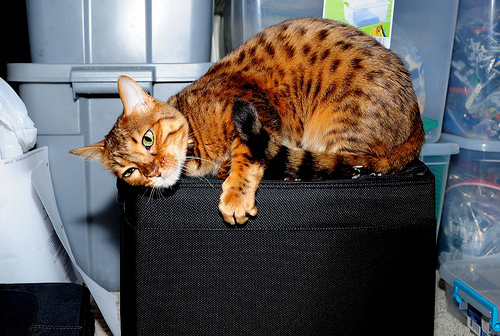

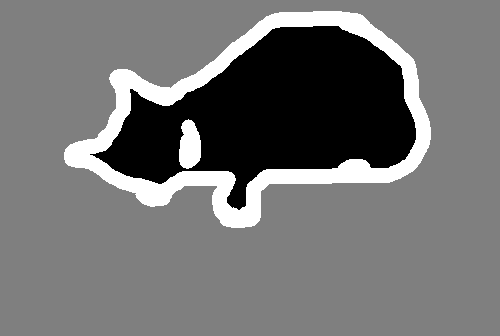

In [4]:
# take a look at the data
from PIL import ImageOps
image, mask = data_shards.first()
display(image)
mask = ImageOps.autocontrast(mask)
display(mask)

In [5]:
# see the num of partitions of data_shards
data_shards.num_partitions()

4

## Transformation of the images

Define a train_transform function directly using methods of torchvision transforms 

In [6]:
img_size = (80, 80)

def train_transform(im):
    im = im[0].resize(img_size), im[1].resize(img_size)
    return np.asarray(im[0]), np.asarray(im[1]) - 1


In [7]:
data_shards = data_shards.transform_shard(train_transform)

Stack elements of each partition into an ndarray of features and labels for efficient training

In [8]:
data_shards = data_shards.stack_feature_labels()

## The model

Build the U-Net model model using tensorflow keras APIs. Here, model is copied from [Keras implementation](https://keras.io/examples/vision/oxford_pets_image_segmentation/).

In [9]:

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

define a model_creator for Orca Estimator and show the summary of model structure

In [10]:
# Build model and compile with optimizer and loss function
num_classes = 3
def model_creator(config):
    model = get_model(img_size, num_classes)
    print(model.summary)
    model.compile(optimizer="rmsprop",
                  loss="sparse_categorical_crossentropy")
    return model

In [ ]:
est = Estimator.from_keras(model_creator=model_creator)

In [ ]:
EPOCHS = 50
BATCH_SIZE = 8
steps_per_epoch = len(data_shards) // BATCH_SIZE

est.fit(data=data_shards,
        batch_size=BATCH_SIZE,
        steps_per_epoch=steps_per_epoch,
        epochs=EPOCHS)

In [ ]:
stop_orca_context()